# DP0.2 Benchmark — Pipeline Fotométrico v1.0  
**Autor:** Marcelo Reyes • **Fecha:** 2025-07-24  

Contenedor LSST:  
```python
import os, datetime, subprocess, sys, lsst
print("Imagen:", os.environ.get("JUPYTERHUB_IMAGE", "N/A"))
print("Pipeline version:", lsst.base.getVersionString())
print("Python:", sys.version.split()[0], "•", datetime.date.today())

## Objetivo

En este _notebook_ pondré a prueba un **pipeline fotométrico mínimo** sobre el conjunto simulado **Data Preview 0.2 (DP0.2)**.  

1. Recuperar ~20 k objetos puntuales (estrellas) desde el catálogo `dp02_dc2_catalogs.Object` mediante TAP.  
2. Construir un **diagrama color–magnitud (CMD)** básico (g − r vs. r).  
3. Aplicar un corte de calidad S/N > 10 y comprobar su impacto en la morfología del CMD.  

El resultado servirá como _benchmark_ “versión 1.0” antes de migrar el mismo flujo de trabajo a **DP1** y, más adelante, al cúmulo 47 Tucanae.


### ¿Por qué DP0.2?  —  Contexto rápido

* **DP0.2** está basado en el **DC2** (_Data Challenge 2_) de LSST DESC: un universo simulado de ~300 deg² que imita cinco años de observaciones LSST.  
* Usarlo como campo de pruebas me da dos ventajas pedagógicas clave:

  1. **Control total**: sé la “verdad” subyacente (objetos y parámetros inyectados).  
  2. **Riesgo ≈ 0**: si rompo algo, no pasa nada; vuelvo a consultar en segundos.

Cuando mejore el pipeline en _datos sintéticos_, pasaremos al **DP1 (ComCam real)** y veremos cuánta “vida real” sobrevive al salto.


In [2]:
from lsst.rsp import get_tap_service
import pandas as pd

svc = get_tap_service("tap")   # TAP autenticado

In [6]:
query_meta = """
SELECT column_name
FROM tap_schema.columns
WHERE table_name = 'dp02_dc2_catalogs.object'
  AND column_name LIKE '%extendedness%'
"""
meta = svc.search(query_meta).to_table().to_pandas()
meta

,column_name
0,g_extendedness
1,g_extendedness_flag
2,i_extendedness
3,i_extendedness_flag
4,r_extendedness
5,r_extendedness_flag
6,refExtendedness
7,u_extendedness
8,u_extendedness_flag
9,y_extendedness


In [7]:
query = """
SELECT
  objectId,
  coord_ra, coord_dec,
  scisql_nanojanskyToAbMag(g_psfFlux) AS mag_g,
  scisql_nanojanskyToAbMag(r_psfFlux) AS mag_r,
  r_extendedness
FROM dp02_dc2_catalogs.Object
WHERE r_extendedness = 0              -- objeto puntual según banda r
  AND r_extendedness_flag = 0         -- métrica de calidad OK
  AND scisql_nanojanskyToAbMag(r_psfFlux) < 24
LIMIT 20000
"""
stars = svc.search(query).to_table().to_pandas()

### Selección de estrellas: la métrica `extendedness`

Rubin/LSST proporciona, para cada banda, un parámetro **`<band>_extendedness`**:

* ≈ 0   → el perfil de luz es **puntual** (PSF-like)  → estrella o QSO.  
* ≈ 1   → perfil **extendido** (galaxia, nebulosa…).

Escoger **`r_extendedness = 0 ∧ r_extendedness_flag = 0`** significa:  
> “Dame objetos puntuales (según la banda _r_) cuya medición pasó los chequeos de calidad de _Science Pipelines_.”

La banda _r_ se usa porque suele tener mejor S/N y calibración más estable que _u_ o _y_ en DC2.


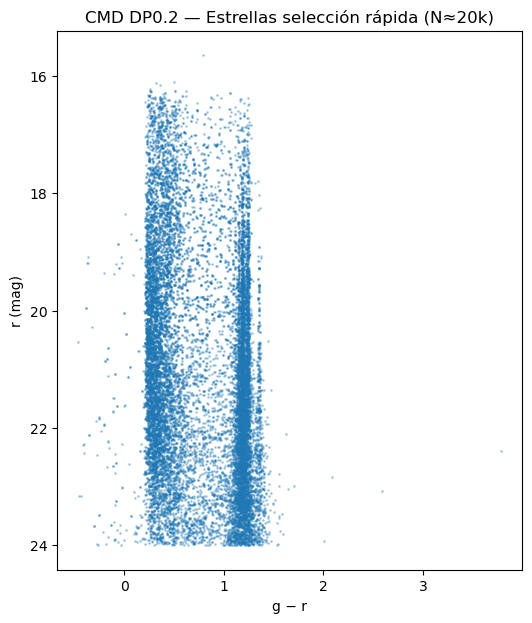

In [8]:
# Construir color y visualizar
stars["g_minus_r"] = stars["mag_g"] - stars["mag_r"]

import matplotlib.pyplot as plt
plt.figure(figsize=(6,7))
plt.scatter(stars["g_minus_r"], stars["mag_r"], s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("g − r")
plt.ylabel("r (mag)")
plt.title("CMD DP0.2 — Estrellas selección rápida (N≈20k)")
plt.show()

### Lectura exprés del CMD

* **Columna azul‐pálida en g − r ≈ 0.25**  
  * Estrellas **tipo F ~ F5**: más masivas/hot que el Sol, muy abundantes en DC2 porque la IMF fue “aligerada” en el rango F–G.

* **Columna densa en g − r ≈ 1.05**  
  * Enanas **K tardías** y M tempranas.  La IMF + la profundidad de DC2 hace que dominen numéricamente.

* **Hueco intermedio (≈ 0.6 – 1.0)**  
  * Mixto (G tardías / K tempranas + subgigantes en tránsito rápido).  
  * Población más rara por las razones de la IMF y el _“Hertzsprung Gap”_ que debatimos antes.

* **Lado izquierdo disperso (< 0.2)**  
  * Pocas estrellas tipo A/B+ ruido (detecciones spúrias o fuentes con gran error en g).  
  * Recordatorio práctico: DP0.2 no está completo para estrellas masivas; el simulador priorizó la estadística de galaxias.

> **Aprendizaje clave**: ya con un _query_ y un scatter sencillo podemos “oler” la física estelar + artefactos del _survey_.  Ese olfato será crucial para no interpretar mal DP1.


In [17]:
query_highQ = """
SELECT
  objectId,
  coord_ra, coord_dec,
  g_psfFlux,  r_psfFlux,
  g_psfFluxErr, r_psfFluxErr,
  scisql_nanojanskyToAbMag(g_psfFlux) AS mag_g,
  scisql_nanojanskyToAbMag(r_psfFlux) AS mag_r,
  r_extendedness
FROM dp02_dc2_catalogs.Object
WHERE r_extendedness = 0
  AND (r_extendedness_flag = 0 OR r_extendedness_flag IS NULL)
  -- S/N > 10  →  err/flux < 0.1
  AND r_psfFluxErr / r_psfFlux < 0.1
  AND g_psfFluxErr / g_psfFlux < 0.1
  -- corte de brillo “r < 24”
  AND scisql_nanojanskyToAbMag(r_psfFlux) < 24
LIMIT 20000
"""
highQ = svc.search(query_highQ).to_table().to_pandas()
highQ["g_minus_r"] = highQ["mag_g"] - highQ["mag_r"]
print(len(highQ), "filas recuperadas")

20000 filas recuperadas


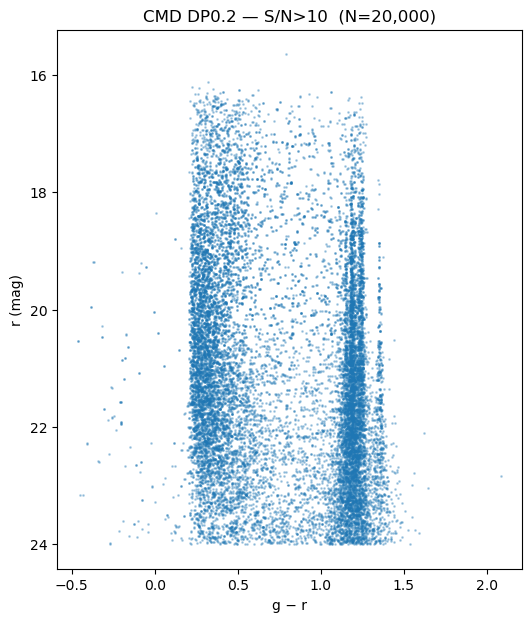

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,7))
plt.scatter(highQ["g_minus_r"], highQ["mag_r"], s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("g − r")
plt.ylabel("r (mag)")
plt.title(f"CMD DP0.2 — S/N>10  (N={len(highQ):,})")
plt.show()